# Active Inference Design Agent (research)

In [3]:
using JLD
using Distributions
using LinearAlgebra
using GraphPPL
using ReactiveMP
using Random 
using WAV
using Plots
using ImageCore
using AIDA
using Parameters
import ProgressMeter

In this demo we will work with two different contexts (environemtns): babble and train noises. 

You can think of a user who keeps wandering around a train station: sometimes train arrives and he/she hears the train noises. When there is no train arriving to the platform, the user hears the babble from people waiting for the train.
When someone starts talking to the user he would (maybe) prefer to damp the environmental noise and focus only on the speaker.

Another possible scenario you can think of is the user who steps out of the train and goes to the bar, where people produce babble noise :D 

## Let's obtain priors for the environment

In [6]:
speech_dir = "../../sound/speech/"
contexts = ["babble", "train"]
input_SNRs = ["0dB", "5dB", "10dB"]
input_fn = "sp01";

To make our model identifiabile, we would like to obtain priors for the environmental noises. To do this, we use Voice-Activity-Detection (VAD) to find the silent segments (with no speech). When those frames are identified, we fit them to AR model of order 2 to learn the parameters of AR.

Surely, you can obtain the priors based on different logic. (to discuss (1) it doesn't have to be AR, (2) it doesn't have to be VAD)

In [7]:
snr_id = 2
wavs = map(x -> wavread("$(speech_dir)$(x)/$(input_SNRs[snr_id])/$(input_fn)_$(x)_sn$(input_SNRs[snr_id][1:end-2]).wav"), contexts)
signals = first.(wavs)
fs = getindex.(wavs, 2)[1]
seg_signals = get_frames.(signals, fs);
totsegs = size.(seg_signals, 1);

### VAD block

In [8]:
@unpack θ, γ, context = JLD.load("memory/context_babble_$(input_SNRs[snr_id]).jld")
# prior for babble noise
bblmη = mean(θ)
bblvη = cov(θ)
bblτ  = (shape(γ), rate(γ));

In [9]:
@unpack θ, γ, context = JLD.load("memory/context_train_$(input_SNRs[snr_id]).jld")
# prior for train noise
trmη = mean(θ)
trvη = cov(θ)
trτ  = (shape(γ), rate(γ));

You can skip this entire block if you used priors from the above cell.

In [ ]:
# compute free energies of two models (gaussian for silent frame, lar for voiced frame)
vads = map(_ -> [], contexts)
ar_order = 10
vmp_iter = 50
for c_num in 1:length(contexts)
    ProgressMeter.@showprogress for segnum in 1:totsegs[c_num]
        vad = model_selection(seg_signals[c_num][segnum, :], 
                              [lar_inference, gaussian_inference],
                              [Dict(:aτ => 1e-4, :bτ => 1e-4, :aγ => 1e-4, :bγ => 1e-4, :order => ar_order), 
                               Dict(:aτ => 1e-4, :bτ => 1e-4)],
                              vmp_iter=vmp_iter)
        push!(vads[c_num], vad)
    end
end

In [10]:
order   = 2
vmp_its = 10

for c_num in 1:length(contexts)
    context_seg = seg_signals[c_num]
    totseg = totsegs[c_num]
    # find voiced and silent frames
    vsegs = findall(isequal(1), vads[c_num]) # voiced frames
    ssegs = findall(isequal(2), vads[c_num]); # silent frames
    signal = get_signal(hcat([context_seg[sseg, :] for sseg in ssegs]...)', fs)
    signal = filter!(a -> a != 0.0, signal)
    inputs, outputs = ar_ssm(signal, order)
    γ, θ, fe = ar_inference(inputs, outputs, order, vmp_its, priors=Dict(:μθ => zeros(order), :Λθ => diageye(order), :aγ => 1.0, :bγ => 1.0))
    println("Context-$(contexts[c_num]) $(mean(θ)), $(cov(θ)), $(shape(γ)), $(rate(γ))")
    JLD.save("memory/context_$(contexts[c_num])_$(input_SNRs[snr_id]).jld", "θ", θ, "γ", γ, "context", contexts[c_num])
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


Context-babble [1.0526046070458872, -0.4232782070078879], [0.0002274117502010668 -0.0001681986150731712; -0.0001681986150731712 0.00022744882724672668], 5144.5, 1.5403421819348209


Progress: 100%|█████████████████████████████████████████| Time: 0:00:05


Context-train [0.497019359872337, -0.15475030421215585], [8.002457029876353e-5 -3.4446944242771045e-5; -3.4446944242771045e-5 8.003099010678723e-5], 7679.5, 4.857063799328507


## Source seperation
When priors for the contexts are indentified, we can run noise reduction algorithm based on coupled AR: AR_speech + AR_envrionment = output. This algorithm seperates speech (**z**) and noise (**x**)

We will split our dataset into training and test set. We use signals from training set to learn the mapping function between the gains proposed by agent and aprraisals provided by user. Bare in mind that this split is not necessary and in theory we can get along without it.

In [20]:
# informative
# map "static" priors to the corresponding matrices with equal element
bblmη_arr, bblvη_arr, bblτ_arr = bblmη, bblvη, bblτ
trmη_arr, trvη_arr, trτ_arr = trmη, trvη, trτ

([0.497019359872337, -0.15475030421215585], [8.002457029876353e-5 -3.4446944242771045e-5; -3.4446944242771045e-5 8.003099010678723e-5], (7679.5, 4.857063799328507))

In [21]:
# weakly informative
bblmη_arr, bblvη_arr, bblτ_arr = zeros(2), diageye(2), bblτ;
trmη_arr, trvη_arr, trτ_arr = zeros(2), diageye(2), trτ

([0.0, 0.0], [1.0 0.0; 0.0 1.0], (7679.5, 4.857063799328507))

In [22]:
# uninfomrmative informative
bblmη_arr, bblvη_arr, bblτ_arr = zeros(2), diageye(2), (100.0, 0.15);
trmη_arr, trvη_arr, trτ_arr = zeros(2), diageye(2), (100.0, 0.15);

In [23]:
db = "5dB"
audio_files = vcat(get_files.(map(x -> "../../sound/speech/$(x)/$(db)", contexts))...);

In [24]:
audio_files = filter!(x -> contains(x, "wav"), audio_files);

In [25]:
# Check for how the data is organized
audio_file = audio_files[8]
println(audio_file)
speech, fs = WAV.wavread(audio_file)
speech_seg = get_frames(speech, fs)

../../sound/speech/babble/5dB/sp08_babble_sn5.wav


380×80 Matrix{Float64}:
  0.0124821    0.0105899    0.00146489   …  -0.00985748    0.0145268
 -0.00766015  -0.0184027    0.003296        -0.00372326   -0.0199286
  0.0262154    0.00979644   0.0133061       -0.00766015   -0.00616474
 -0.0069277   -0.00656148  -0.0177313        0.0105594     0.0203864
 -0.011597    -0.00241096  -0.0069277       -0.0133061    -0.0186468
 -0.0176702   -0.0256966   -0.0152287    …  -0.0315867    -0.0348521
 -0.0147099   -0.00439467  -0.00103763       0.0335398     0.0371105
  0.0440687    0.0233161    0.0130314       -0.0137944    -0.0118107
 -0.027192    -0.0391552   -0.0315867        0.0154424     0.0127873
 -0.0266732   -0.00750755   0.00442518      -0.00811792   -0.0104984
 -0.0130619   -0.00466933   0.000579852  …  -0.00689718   -0.00701926
  0.0160527    0.0143742    0.00570696       0.00262459   -0.0044557
 -0.00210578  -0.0130924   -0.0373241        0.00756859   -0.00708029
  ⋮                                      ⋱                
 -0.0213324   -0.

At this stage we run our inference algorithm to seperate **z** and **x**. We write the output into *.jld* files.

You don't need to run this snippet if you haven't changed the default parameters of HA_algorithm and priors (just see *sound/AIDA/separated_jld/training/*)

In [27]:
# r for recovered
ar_speech = 10
ar_env = 2
vmp_iter = 30

for audio_file in audio_files
    if !occursin(".wav", audio_file) continue end
    
    if occursin("/$(contexts[1])/", audio_file)
        priors_eta = (bblmη_arr, bblvη_arr)
        priors_tau = bblτ_arr
    elseif occursin("/$(contexts[2])/", audio_file)
        priors_eta = (trmη_arr, trvη_arr)
        priors_tau = trτ_arr
    else
        continue
    end
    
    speech, fs = WAV.wavread(audio_file)
    speech_seg = get_frames(speech, fs)
    
    # make sure that 1D of priors and speech_seg are equal
    if size(priors_eta, 1) != size(speech_seg, 1)
        totseg = size(speech_seg, 1)
        priors_eta_m, priors_eta_v, priors_tau = prior_to_priors(priors_eta[1][1, :]', priors_eta[2][1, :, :], priors_tau[1], totseg, ar_env)
        priors_eta = priors_eta_m, priors_eta_v
    end
    
    rmz, rvz, rmθ, rvθ, rγ, rmx, rvx, rmη, rvη, rτ, fe = batch_coupled_learning(speech_seg, priors_eta, priors_tau, ar_speech, ar_env, vmp_iter);
    
    JLD.save("../../sound/separated_jld/"*audio_file[findfirst("sp", audio_file)[1]:end][1:end-3]*"jld",
         "rmz", rmz, "rvz", rvz, "rmθ", rmθ, "rvθ", rvθ, "rγ", rγ, 
         "rmx", rmx, "rvx", rvx, "rmη", rmη, "rvη", rvη, "rτ", rτ,
         "fe", fe, "filename", audio_file)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:09:35
Progress: 100%|█████████████████████████████████████████| Time: 0:07:38
Progress: 100%|█████████████████████████████████████████| Time: 0:04:47
Progress: 100%|█████████████████████████████████████████| Time: 0:03:21
Progress: 100%|█████████████████████████████████████████| Time: 0:03:18
Progress: 100%|█████████████████████████████████████████| Time: 0:04:01
Progress: 100%|█████████████████████████████████████████| Time: 0:03:42
Progress: 100%|█████████████████████████████████████████| Time: 0:04:13
Progress: 100%|█████████████████████████████████████████| Time: 0:04:29
Progress: 100%|█████████████████████████████████████████| Time: 0:03:58
Progress: 100%|█████████████████████████████████████████| Time: 0:04:20
Progress: 100%|█████████████████████████████████████████| Time: 0:04:05
Progress: 100%|█████████████████████████████████████████| Time: 0:03:46
Progress: 100%|█████████████████████████████████████████| Time: 

## Context inference

In [29]:
# r for recovered
ar_env = 2
vmp_iter = 5
active_contexts = []
active_models = []
for audio_file in audio_files
    if !occursin(".wav", audio_file) continue end
    
    speech, fs = WAV.wavread(audio_file)
    speech_seg = get_frames(speech, fs)
    vad = model_selection(speech_seg[1, :], 
                              [lar_inference, lar_inference], 
                              [Dict(:mθ => [1.0526046070458872, -0.4232782070078879], 
                                    :vθ => [0.0002274117502010668 -0.0001681986150731712; -0.0001681986150731712 0.00022744882724672668], 
                                    :aγ => 5144.5, :bγ => 1.5403421819348209, 
                                    :τ  => 1e12, :order=>ar_env),
                              Dict(:mθ => [0.497019359872337, -0.15475030421215585], 
                                   :vθ => [8.002457029876353e-5 -3.4446944242771045e-5; -3.4446944242771045e-5 8.003099010678723e-5], 
                                   :aγ => 7679.5, :bγ => 4.857063799328507, 
                                   :τ  => 1e12, :order=>ar_env)],
                              vmp_iter=vmp_iter)
    push!(active_models, vad)
    if occursin("/$(contexts[1])/", audio_file)
        push!(active_contexts, 1.0)
    elseif occursin("/$(contexts[2])/", audio_file)
        push!(active_contexts, 2.0)
    else
        continue
    end
end

In [30]:
cat_accuracy(active_contexts, active_models)

0.75

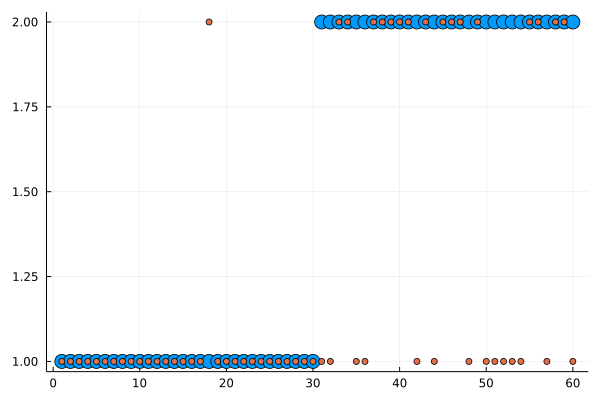

In [31]:
scatter(active_contexts, markersize=8.0)
scatter!(active_models, legend=false)

### HA output generator

In [54]:
# obtain saved jld files containing inference result
audio_jlds = get_files("../sound/separated_jld/speech");
filter!(x -> occursin("jld", x), audio_jlds)

60-element Vector{Any}:
 "../sound/separated_jld/speech/babble/5dB/sp01_babble_sn5.jld"
 "../sound/separated_jld/speech/babble/5dB/sp02_babble_sn5.jld"
 "../sound/separated_jld/speech/babble/5dB/sp03_babble_sn5.jld"
 "../sound/separated_jld/speech/babble/5dB/sp04_babble_sn5.jld"
 "../sound/separated_jld/speech/babble/5dB/sp05_babble_sn5.jld"
 "../sound/separated_jld/speech/babble/5dB/sp06_babble_sn5.jld"
 "../sound/separated_jld/speech/babble/5dB/sp07_babble_sn5.jld"
 "../sound/separated_jld/speech/babble/5dB/sp08_babble_sn5.jld"
 "../sound/separated_jld/speech/babble/5dB/sp09_babble_sn5.jld"
 "../sound/separated_jld/speech/babble/5dB/sp10_babble_sn5.jld"
 "../sound/separated_jld/speech/babble/5dB/sp11_babble_sn5.jld"
 "../sound/separated_jld/speech/babble/5dB/sp12_babble_sn5.jld"
 "../sound/separated_jld/speech/babble/5dB/sp13_babble_sn5.jld"
 ⋮
 "../sound/separated_jld/speech/train/5dB/sp19_train_sn5.jld"
 "../sound/separated_jld/speech/train/5dB/sp20_train_sn5.jld"
 "../sound/separa

In [56]:
# initialize gains that agent randomly assigns to the outputs of HA
agent_gains = [[2.0, 1.0], [1.0, 0.0], [0.5, 0.5], [0.9, 0.3], [2.5, 1.0], [0.9, 0.1], [0.7, 0.2], [0.2, 0.7], [2.0, 0.0]];

In [61]:
# this snippet generates new ha outputs
for audio_jld in audio_jlds
    # read file
    d = JLD.load(audio_jld)
    filename = d["filename"]
    # extract speech and noise
    rz, rx = get_signal(d["rmz"], fs), get_signal(d["rmx"], fs)
    # pick weights 
    whgs = rand(agent_gains) # can be changed to a smarter function
    # create output
    ha_out = whgs[1] .* rz + whgs[2] .* rx
    # write wav file
    WAV.wavwrite(ha_out, fs, "../sound/preference_learning/ha_out_$(whgs[1])_$(whgs[2])_"*filename[findfirst("dB", filename)[1]+3:end])
end

#### Create pairs (gains, context) <-> appraisals

In [107]:
# Recorded gains and appraisals 
# If you want to generate new pairs, please procceed with listening
preferences = JLD.load("../src/memory/preferences.jld")
@unpack gains, appraisals, contexts = preferences

Dict{String, Any} with 3 entries:
  "gains"      => [[2.0, 1.0], [2.0, 1.0], [2.5, 1.0], [1.0, 0.0], [0.5, 0.5], …
  "appraisals" => [0.5, 0.4, 0.5, 0.9, 0.5, 0.4, 0.5, 0.9, 0.3, 0.7  …  0.7, 0.…
  "contexts"   => [1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0  …  1.0, 0.…